In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path("..").resolve()))

In [2]:
import torch.multiprocessing as mp
mp.set_sharing_strategy("file_system")

In [3]:
import torch
from torch.utils.data import DataLoader
from datasets.cfg import num_classes, max_size
from models.models import build_model
from datasets.loader import DataModule, DataConfig
from datasets.base import collate_bb
from train.eval import Evaluator
from train.unsupervised_metrics import UnlabeledSanity
import mlflow.pytorch
device = torch.device("cuda")

model_B = build_model("maskrcnn_r50_fpn", num_classes).to(device)
model_B.load_state_dict(torch.load("../weights/maskrcnn_B_ep40.pth", map_location="cuda"))

model_uri = "file:///media/sdb1/mlflow/753485487056022103/a7b0ebbbad47442c841112c6bfb35e16/artifacts/model"
model_AB_Att = mlflow.pytorch.load_model(model_uri)



/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/tmp/ipykernel_1924607/1664154340.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value 

In [4]:
data = DataModule(DataConfig())
loader_B_test = data.make_loader_b_test()
loader_A_val  = data.make_loader_a_val()
loader_D_test  = data.make_loader_d_test()
e = Evaluator(device)

In [5]:
mb_B  = e.metrics_masks_split(model_B,  loader_B_test, num_classes=num_classes - 1)
mb_AB_Att = e.metrics_masks_split(model_AB_Att, loader_B_test, num_classes=num_classes - 1)

rows = [
    ["setup", "mAP50", "PQ_all", "mPQ", "AJI"],
    ["Model B", f"{mb_B['mAP50']:.3f}",  f"{mb_B['PQ_all']:.3f}",  f"{mb_B['mPQ']:.3f}",  f"{mb_B['AJI']:.3f}"],
    ["Model AttFPN A+B",   f"{mb_AB_Att['mAP50']:.3f}", f"{mb_AB_Att['PQ_all']:.3f}", f"{mb_AB_Att['mPQ']:.3f}", f"{mb_AB_Att['AJI']:.3f}"],
]
print("\n=== B-test metrics ===")
e.print_table(rows)


=== B-test metrics ===
setup             mAP50  PQ_all  mPQ    AJI  
Model B           0.885  0.582   0.581  0.504
Model AttFPN A+B  0.893  0.636   0.634  0.571


In [6]:
def metrics_row(name, m):
    return [
        name,
        f"{m['mAP50']:.3f}",
        f"{m['PQ_all']:.3f}",
        f"{m['mPQ']:.3f}",
        f"{m['AJI']:.3f}",
    ]


def metrics_rows_split(name, m):
    rows = [metrics_row(name, m)]
    if "short" in m and "long" in m:
        rows.append(metrics_row(f"{name} (short)", m["short"]))
        rows.append(metrics_row(f"{name} (long)",  m["long"]))
    return rows

rows = [
    ["setup", "mAP50", "PQ_all", "mPQ", "AJI"],
    *metrics_rows_split("Model B", mb_B), *metrics_rows_split("Model AB Att", mb_AB_Att) ]
e.print_table(rows)

setup                 mAP50  PQ_all  mPQ    AJI  
Model B               0.885  0.582   0.581  0.504
Model B (short)       0.678  0.524   0.422  0.445
Model B (long)        0.770  0.625   0.534  0.534
Model AB Att          0.893  0.636   0.634  0.571
Model AB Att (short)  0.691  0.579   0.495  0.521
Model AB Att (long)   0.824  0.681   0.602  0.594


In [ ]:
mb_B  = e.metrics_masks(model_B,  loader_B_test, num_classes=num_classes - 1)
mb_AB_Att = e.metrics_masks(model_AB_Att, loader_B_test, num_classes=num_classes - 1)

rows = [
    ["setup", "mAP50", "PQ_all", "mPQ", "AJI"],
    ["Model B", f"{mb_B['mAP50']:.3f}",  f"{mb_B['PQ_all']:.3f}",  f"{mb_B['mPQ']:.3f}",  f"{mb_B['AJI']:.3f}"],
    ["Model AttFPN A+B",   f"{mb_AB_Att['mAP50']:.3f}", f"{mb_AB_Att['PQ_all']:.3f}", f"{mb_AB_Att['mPQ']:.3f}", f"{mb_AB_Att['AJI']:.3f}"],
]
print("\n=== B-test metrics ===")
e.print_table(rows)

In [8]:
sanity = UnlabeledSanity(num_classes=24)

san_scores_b_b = e.sanity(model_B, loader_B_test, sanity)
san_scored_att_b = e.sanity(model_AB_Att, loader_B_test, sanity)

san_scores_b_d = e.sanity(model_B, loader_D_test, sanity)
san_scored_att_d = e.sanity(model_AB_Att, loader_D_test, sanity)

In [11]:
ds = san_scores_b_b["dataset_scores"]

print("\n=== Unlabeled B-test sanity (B model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

ds = san_scored_att_b["dataset_scores"]
print("\n=== Unlabeled B-test sanity (Attention model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

ds = san_scores_b_d["dataset_scores"]
print("\n=== Unlabeled D-test sanity (B model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

ds = san_scored_att_d["dataset_scores"]
print("\n=== Unlabeled D-test sanity (Attention model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")


=== Unlabeled B-test sanity (B model) ===
total: 0.483 count: 0.284 balance: 0.423 sex: 0.284 size: 0.940

=== Unlabeled B-test sanity (Attention model) ===
total: 0.603 count: 0.485 balance: 0.539 sex: 0.455 size: 0.933

=== Unlabeled D-test sanity (B model) ===
total: 0.311 count: 0.001 balance: 0.286 sex: 0.078 size: 0.878

=== Unlabeled D-test sanity (Attention model) ===
total: 0.419 count: 0.116 balance: 0.343 sex: 0.281 size: 0.934



Examples: B-test, B model


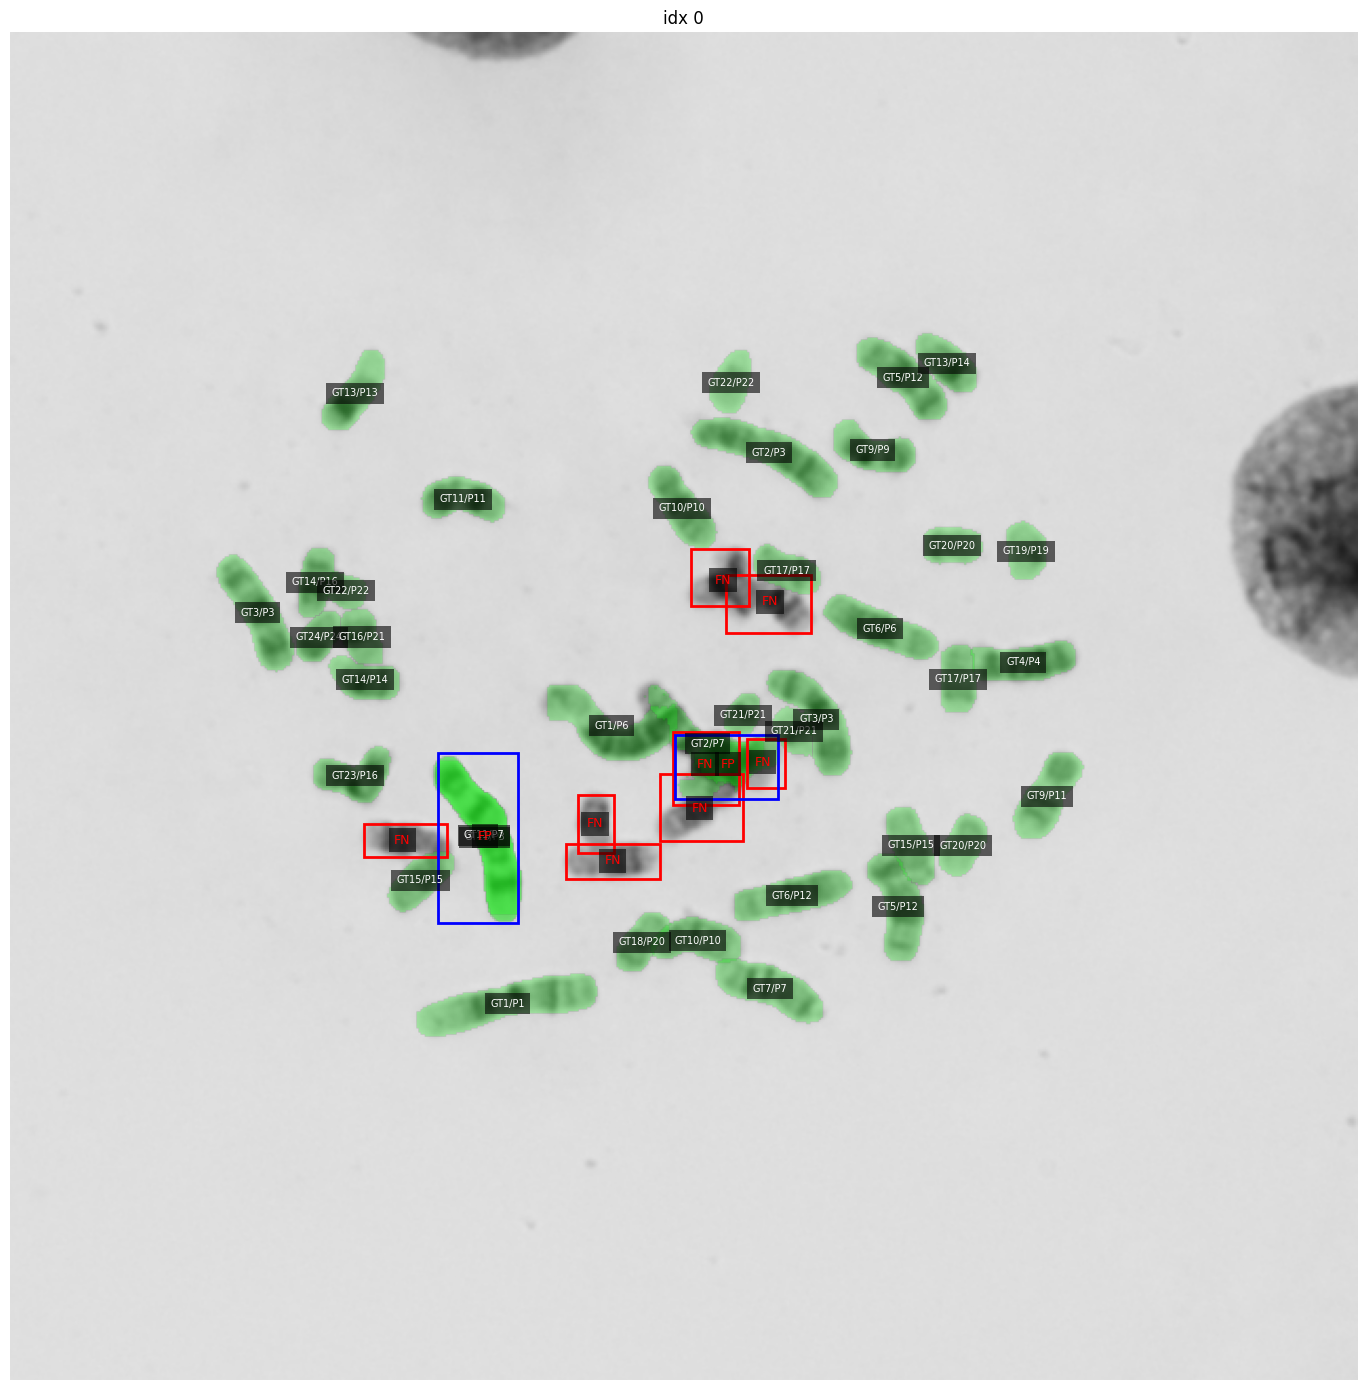


Examples: B-test, Att model


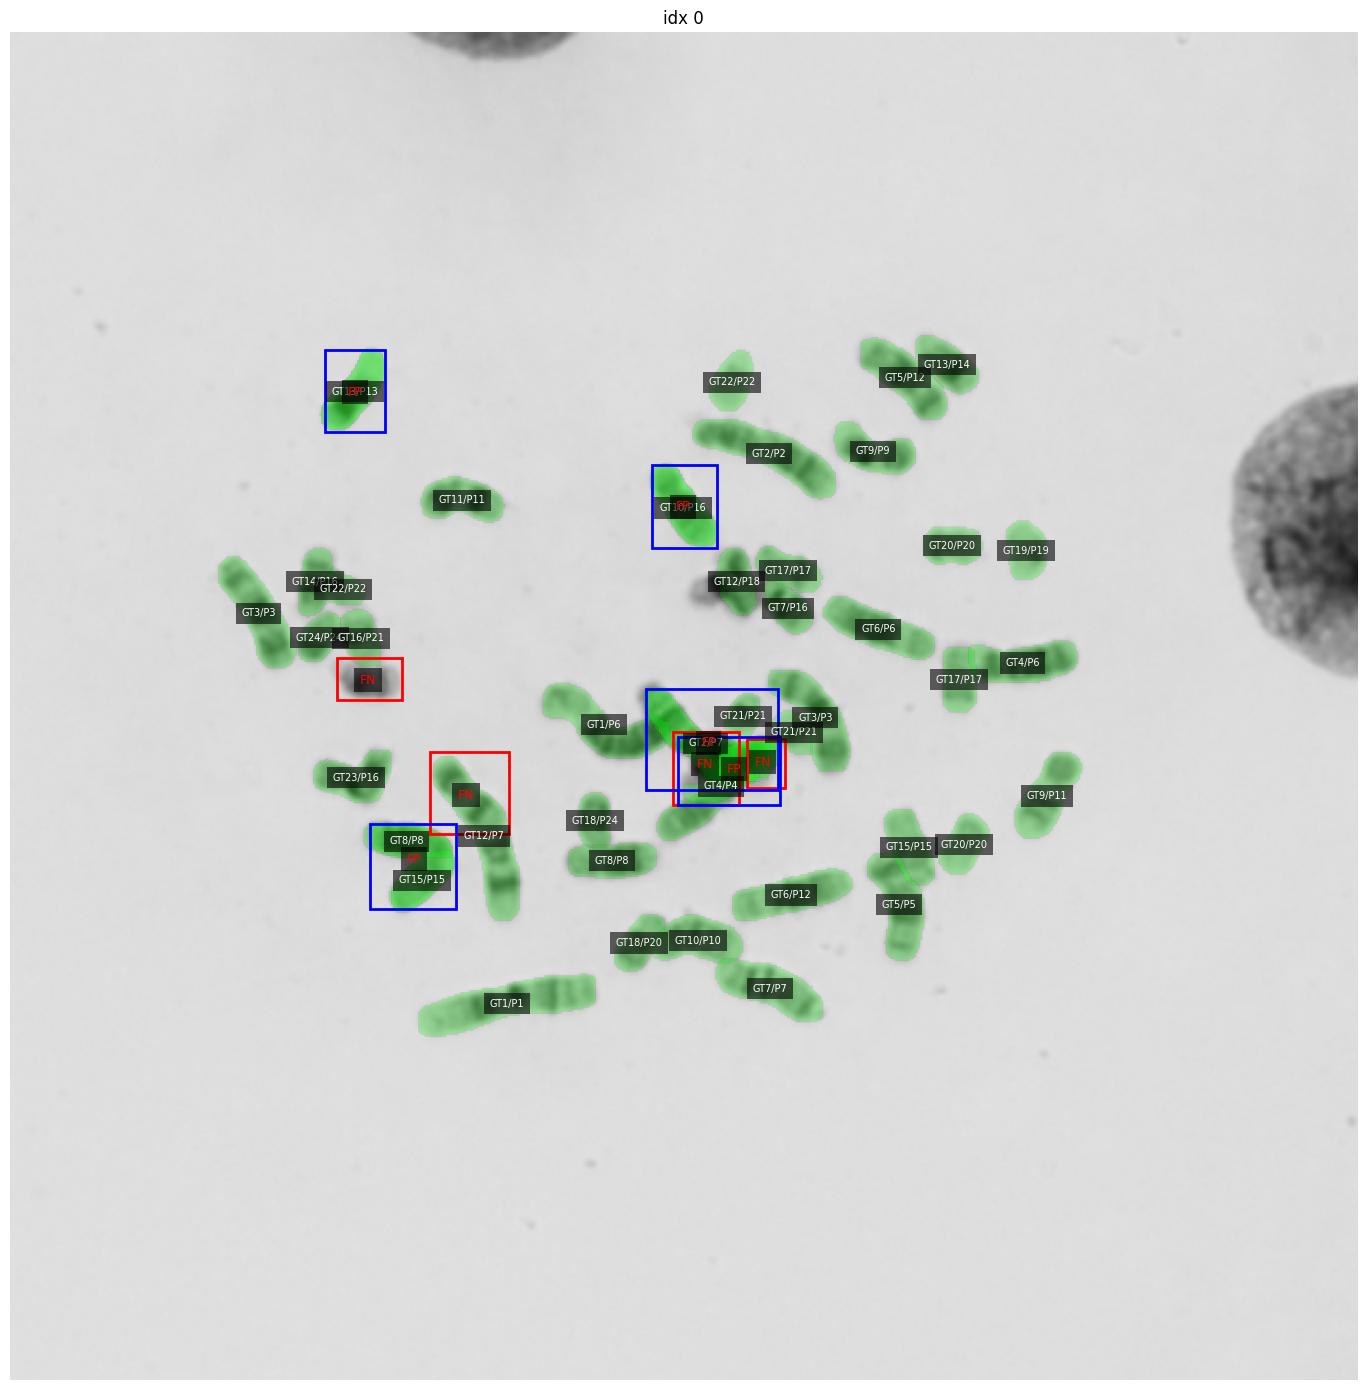

In [7]:
e.show_examples(data.ds_b_test, model_B,  n=1, score_thresh=0.5, iou_thresh=0.4, title="B-test, B model")
e.show_examples(data.ds_b_test, model_AB_Att, n=1, score_thresh=0.5, iou_thresh=0.4, title="B-test, Att model")

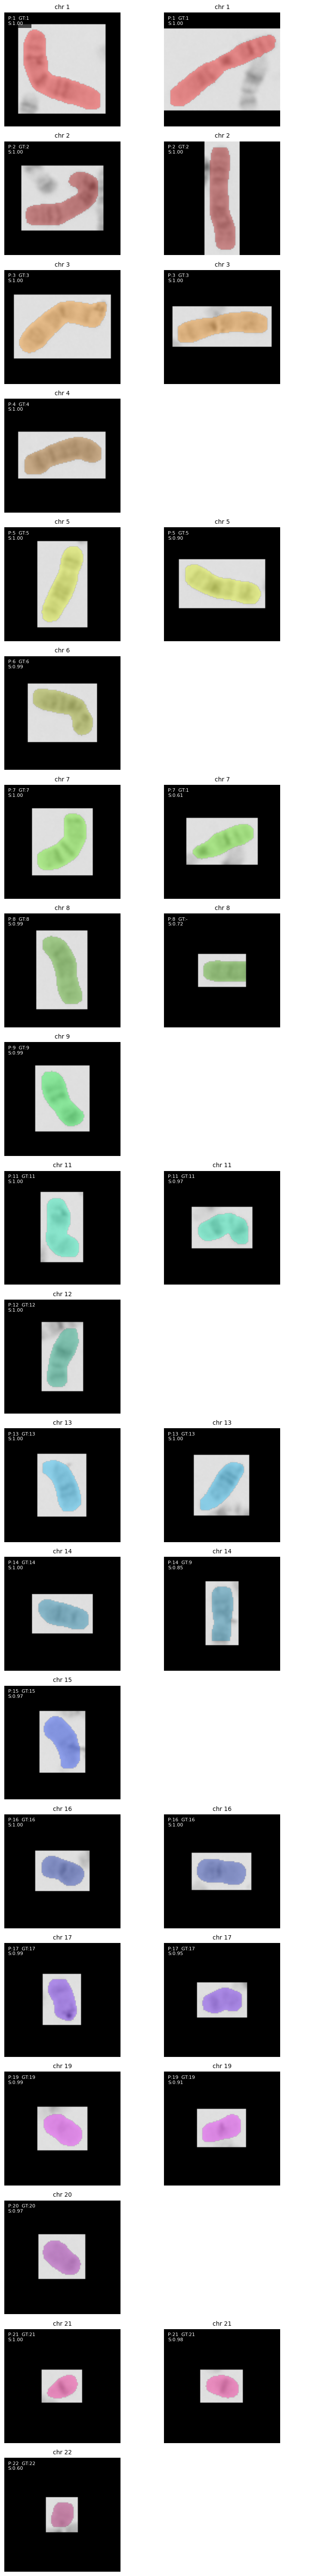

In [9]:

from train.karyo_plotting4 import plot_karyogram_from_output

def plot_karyogram_from_dataset(dataset, model, idx=0, score_thresh=0.5, pad=5):
    model.eval()
    img_t, target = dataset[idx]
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    plot_karyogram_from_output(img_t.cpu(), out, target, idx=idx, score_thresh=score_thresh, pad=pad)

plot_karyogram_from_dataset(data.ds_b_test, model_AB_Att, idx= 1)

In [16]:
from train.karyo_plotting2 import plot_karyogram_from_output

def plot_karyogram_from_dataset(dataset, model, idx=0, score_thresh=0.5,pad=5,cols=8):
    model.eval()
    img_t, _ = dataset[idx]
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    plot_karyogram_from_output(img_t.cpu(), out, idx, score_thresh, pad, cols)

plot_karyogram_from_dataset(data.ds_b_test, model_AB, idx= 1)

NameError: name 'model_AB' is not defined